In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, AUC
from tensorflow.keras.callbacks import ModelCheckpoint

import pydicom
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import pandas as pd
import os
import glob

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split 

print("Configuração inicial e imports concluídos.")

Configuração inicial e imports concluídos.


## Preparação dos Dados e Data Augmentation Em Tempo Real

In [ ]:
"""
- DEFINIÇÃO DAS CAMADAS DE AUMENTAÇÃO DE DADOS:

Define uma sequência de camadas de aumentação de dados para introduzir
variações nas imagens de treinamento, incluindo Flip Horizontal, Rotação (10%), Zoom (10%) e Contraste (10%).

Vantagens do Data Augmentation 'on-the-fly':
    - Diversifica os Dados: Cria variações únicas a cada época, expondo o modelo a uma gama maior de exemplos.
    - Economiza Armazenamento: Não é preciso salvar todas as imagens aumentadas; as transformações são feitas dinamicamente.
    - Melhora a Generalização
"""

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ],
    name="data_augmentation",
)

In [ ]:
"""
- PREPARA OS DADOS GERANDO UM DATAFRAME:

Prepara dados, criando um único DataFrame com os rótulos,
caminhos de imagem e informações dos bounding boxes.
"""

# Configuração de caminhos
image_base_dir = 'rsna-pneumonia-detection-challenge/stage_2_train_images'
annotation_file_path = 'rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'
detailed_info_path = 'rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv'

# Carregar Dados
annotations_df = pd.read_csv(annotation_file_path)
detailed_info_df = pd.read_csv(detailed_info_path)

dcm_files = glob.glob(os.path.join(image_base_dir, '*.dcm'))
patient_id_to_path = {os.path.splitext(os.path.basename(dcm_path))[0]: dcm_path for dcm_path in dcm_files}

patient_id_to_annotations = {}
for patient_id, group in annotations_df.groupby('patientId'):
    patient_id_to_annotations[patient_id] = group.to_dict('records')

patient_id_to_detailed_class = detailed_info_df.set_index('patientId')['class'].to_dict()

# Criar o DataFrame images_with_boxes_df
data_for_df = []
available_patient_ids = list(patient_id_to_path.keys())

for patient_id in available_patient_ids:
    patient_annotations = annotations_df[annotations_df['patientId'] == patient_id].to_dict('records')

    if not patient_annotations:
        detailed_class = patient_id_to_detailed_class.get(patient_id, 'Unknown')
        data_for_df.append({
            'patientId': patient_id,
            'image_path': patient_id_to_path.get(patient_id),
            'Target': 0 if 'Normal' in detailed_class else 1,
            'detailed_class': detailed_class,
            'boxes': [],
            'num_boxes': 0
        })
        continue

    image_target = patient_annotations[0]['Target']
    image_path = patient_id_to_path.get(patient_id)

    boxes = []
    if image_target == 1:
        for ann in patient_annotations:
            if not pd.isna(ann['x']) and ann['Target'] == 1:
                x, y, w, h = ann['x'], ann['y'], ann['width'], ann['height']
                boxes.append([x, y, x + w, y + h])

    detailed_class = patient_id_to_detailed_class.get(patient_id, 'Unknown')

    if image_path:
        data_for_df.append({
            'patientId': patient_id,
            'image_path': image_path,
            'Target': image_target,
            'detailed_class': detailed_class,
            'boxes': boxes,
            'num_boxes': len(boxes)
        })

images_with_boxes_df = pd.DataFrame(data_for_df)

print("Dados carregados e DataFrame de imagens criado.")
print(f"Número de imagens no DataFrame: {len(images_with_boxes_df)}")
print(f"Distribuição da classe Target:\n{images_with_boxes_df['Target'].value_counts()}")

Dados carregados e DataFrame de imagens criado.
Número de imagens no DataFrame: 26684
Distribuição da classe Target:
Target
0    20672
1     6012
Name: count, dtype: int64


In [ ]:
"""
- SEPARAÇÃO EM TREINO, VALIDAÇÃO E TESTE (70% / 15% / 15%):

Define um pipeline de pré-processamento de imagens para o treinamento.
Inclui funções para carregar, pré-processar e transformar imagens,
além de criar e configurar datasets para treino, validação e teste.
"""

# Função para carregar e pré-processar uma única imagem DICOM
def load_and_preprocess_image_tf(image_path, label):
    # Carrega imagem DICOM e pré-processa.
    image_path_str = image_path.numpy().decode('utf-8')
    dcm_data = pydicom.dcmread(image_path_str)
    image = dcm_data.pixel_array
    image = image.astype(np.float32)
    min_val = image.min()
    max_val = image.max()
    if max_val - min_val > 0:
        image = (image - min_val) / (max_val - min_val) * 255.0
    else:
        image = np.zeros_like(image, dtype=np.float32)
    image = np.stack([image] * 3, axis=-1)
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    label_tensor = tf.convert_to_tensor(label, dtype=tf.float32)
    return image_tensor, label_tensor

# Função Wrapper para tf.py_function
def tf_load_and_preprocess(image_path, label):
    # Wrapper para chamar load_and_preprocess_image_tf com tf.py_function.
    image, label = tf.py_function(
        load_and_preprocess_image_tf,
        [image_path, label],
        [tf.float32, tf.float32]
    )
    image.set_shape((256, 256, 3))
    label.set_shape(())
    return image, label

# Definição das Transformações de Imagem com TensorFlow Ops
def apply_transformations(image, label):
    # Aplica redimensionamento e normalização usando TensorFlow Ops.
    image = tf.image.resize(image, (256, 256))
    image = image / 255.0
    mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
    std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)
    image = (image - mean) / std
    return image, label

# Divisão dos Dados
train_df, temp_df = train_test_split(images_with_boxes_df, test_size=0.3, random_state=42, stratify=images_with_boxes_df['Target'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Target'])

# Converter labels para float32 ANTES de criar o Dataset
train_paths = train_df['image_path'].values
train_labels = train_df['Target'].values.astype(np.float32)

val_paths = val_df['image_path'].values
val_labels = val_df['Target'].values.astype(np.float32)

test_paths = test_df['image_path'].values
test_labels = test_df['Target'].values.astype(np.float32)

# Criação dos TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

# Construir o Pipeline de Dados
batch_size = 32
buffer_size = tf.data.AUTOTUNE

# Pipeline para Treino
train_dataset = train_dataset.map(tf_load_and_preprocess, num_parallel_calls=buffer_size)
train_dataset = train_dataset.map(apply_transformations, num_parallel_calls=buffer_size)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)

# Pipeline para Validação e Teste
val_dataset = val_dataset.map(tf_load_and_preprocess, num_parallel_calls=buffer_size)
val_dataset = val_dataset.map(apply_transformations, num_parallel_calls=buffer_size)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=buffer_size)

test_dataset = test_dataset.map(tf_load_and_preprocess, num_parallel_calls=buffer_size)
test_dataset = test_dataset.map(apply_transformations, num_parallel_calls=buffer_size)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=buffer_size)

print("Pipeline de dados do TensorFlow criado com correção de dtype.")

Pipeline de dados do TensorFlow criado com correção de dtype.


In [ ]:
print(f"Tamanho do conjunto de treino: {len(train_df)}")
print(f"Tamanho do conjunto de validação: {len(val_df)}")
print(f"Tamanho do conjunto de teste: {len(test_df)}")

Tamanho do conjunto de treino: 18678
Tamanho do conjunto de validação: 4003
Tamanho do conjunto de teste: 4003


In [ ]:
"""
- REALIZA BALANCEAMENTO DE CLASSES E RECONSTRÓI PIPELINES DE DADOS:

Esta célula foca no balanceamento das classes dos DataFrames de treino, validação e teste,
especialmente nas colunas 'Target' e 'detailed_class', para garantir uma distribuição
mais equitativa dos dados. Após o balanceamento, os pipelines de dados do TensorFlow
são recriados utilizando os DataFrames balanceados.
"""

def balance_dataframe(df_to_balance, target_class_counts=None, random_seed=42):
    # Balanceia um DataFrame com base nas classes 'Target' e 'detailed_class'.
    np.random.seed(random_seed)

    df_neg = df_to_balance[df_to_balance['Target'] == 0].copy()
    df_pos = df_to_balance[df_to_balance['Target'] == 1].copy()

    num_pos_samples_target = len(df_pos) if target_class_counts is None else target_class_counts.get(1, len(df_pos))

    if len(df_pos) < num_pos_samples_target:
        print(f"Warning: Not enough positive samples to reach target {num_pos_samples_target}. Oversampling positive samples with replacement.")
        df_pos_balanced = df_pos.sample(n=num_pos_samples_target, replace=True, random_state=random_seed)
    else:
        df_pos_balanced = df_pos.sample(n=num_pos_samples_target, random_state=random_seed)

    df_normal = df_neg[df_neg['detailed_class'] == 'Normal'].copy()
    df_not_normal = df_neg[df_neg['detailed_class'] == 'Not normal'].copy()

    num_neg_samples_target = num_pos_samples_target
    num_neg_samples_per_detailed_class = num_neg_samples_target // 2

    df_normal_sampled = df_normal.sample(n=min(len(df_normal), num_neg_samples_per_detailed_class),
                                         replace=(len(df_normal) < num_neg_samples_per_detailed_class),
                                         random_state=random_seed)
    df_not_normal_sampled = df_not_normal.sample(n=min(len(df_not_normal), num_neg_samples_per_detailed_class),
                                                  replace=(len(df_not_normal) < num_neg_samples_per_detailed_class),
                                                  random_state=random_seed)

    df_neg_balanced = pd.concat([df_normal_sampled, df_not_normal_sampled])

    if len(df_neg_balanced) < num_neg_samples_target:
        df_neg_balanced = df_neg_balanced.sample(n=num_neg_samples_target, replace=True, random_state=random_seed)
    elif len(df_neg_balanced) > num_neg_samples_target:
        df_neg_balanced = df_neg_balanced.sample(n=num_neg_samples_target, random_state=random_seed)

    balanced_df = pd.concat([df_neg_balanced, df_pos_balanced]).sample(frac=1, random_state=random_seed).reset_index(drop=True)

    print(f"\nBalancing complete for a split. Stats for this balanced DataFrame:")
    print(f"  Total samples: {len(balanced_df)}")
    print(f"  Target distribution:\n{balanced_df['Target'].value_counts()}")
    print(f"  Detailed class for Target=0:\n{balanced_df[balanced_df['Target'] == 0]['detailed_class'].value_counts()}")
    print(f"  Num boxes for Target=1:\n{balanced_df[balanced_df['Target'] == 1]['num_boxes'].value_counts()}")

    return balanced_df

print("Applying balancing to Training DataFrame...")
balanced_train_df = balance_dataframe(train_df, random_seed=42)

print("\nApplying balancing to Validation DataFrame...")
balanced_val_df = balance_dataframe(val_df, random_state=42)

print("\nApplying balancing to Test DataFrame...")
balanced_test_df = balance_dataframe(test_df, random_state=42)


def create_tf_dataset_pipeline(df, buffer_size, batch_size):
    # Cria e pré-processa um TensorFlow Dataset.
    paths = df['image_path'].values
    labels = df['Target'].values.astype(np.float32)

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(tf_load_and_preprocess, num_parallel_calls=buffer_size)
    dataset = dataset.map(apply_transformations, num_parallel_calls=buffer_size)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=buffer_size)
    return dataset

print("\nRe-creating TensorFlow Datasets with balanced data...")

balanced_train_dataset = create_tf_dataset_pipeline(balanced_train_df, buffer_size, batch_size)
balanced_val_dataset = create_tf_dataset_pipeline(balanced_val_df, buffer_size, batch_size)
balanced_test_dataset = create_tf_dataset_pipeline(balanced_test_df, buffer_size, batch_size)

print("Balanced TensorFlow Datasets (train, val, test) created successfully.")

Applying balancing to Training DataFrame...

Balancing complete for a split. Stats for this balanced DataFrame:
  Total samples: 8416
  Target distribution:
Target
1    4208
0    4208
Name: count, dtype: int64
  Detailed class for Target=0:
detailed_class
Normal    4208
Name: count, dtype: int64
  Num boxes for Target=1:
num_boxes
2    2263
1    1855
3      81
4       9
Name: count, dtype: int64

Applying balancing to Validation DataFrame...

Balancing complete for a split. Stats for this balanced DataFrame:
  Total samples: 1804
  Target distribution:
Target
1    902
0    902
Name: count, dtype: int64
  Detailed class for Target=0:
detailed_class
Normal    902
Name: count, dtype: int64
  Num boxes for Target=1:
num_boxes
2    473
1    408
3     17
4      4
Name: count, dtype: int64

Applying balancing to Test DataFrame...

Balancing complete for a split. Stats for this balanced DataFrame:
  Total samples: 1804
  Target distribution:
Target
1    902
0    902
Name: count, dtype: int64
 

## Modelo Resnet50 com Balanceamento e Descongelamento das 10 Camadas: 

In [ ]:
"""
- DEFINIÇÃO DO MODELO RESNET50 PARA CLASSIFICAÇÃO BINÁRIA COM DATA AUGMENTATION
"""

# Definição do Modelo Keras
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congela as camadas do modelo base
base_model.trainable = False

model = keras.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

print("Modelo definido com augmentação em tempo real.")
model.summary()

✅ Modelo definido com augmentação em tempo real.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
"""
- DESCONGELAMENTO E COMPILAÇÃO DO MODELO PARA FINE-TUNING:

Descongela as últimas 10 camadas convolucionais e de Batch Normalization da base do modelo.
Em seguida, o modelo é recompilado com uma taxa de aprendizado mais baixa
para permitir o treinamento dessas camadas.
"""

print("\n--- Etapa de Fine-tuning: Descongelando as últimas 5 camadas convolucionais ---")

# Descongela a base do modelo
base_model.trainable = True

# Descongela as últimas 10 camadas convolucionais e de Batch Normalization
num_layers_to_unfreeze = 10
unfrozen_count = 0
for layer in reversed(base_model.layers):
    if unfrozen_count < num_layers_to_unfreeze:
        if isinstance(layer, (layers.Conv2d, layers.BatchNormalization)):
            layer.trainable = True
            unfrozen_count += 1
            print(f"Descongelando camada: {layer.name}")
        else:
            layer.trainable = True
    else:
        layer.trainable = False

# Recompila o modelo para aplicar as mudanças
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\nModelo após descongelar as últimas 10 camadas convolucionais:")
model.summary(expand_nested=True)


--- Etapa de Fine-tuning: Descongelando as últimas 5 camadas convolucionais ---
Descongelando camada: conv5_block3_3_bn
Descongelando camada: conv5_block3_3_conv
Descongelando camada: conv5_block3_2_bn
Descongelando camada: conv5_block3_2_conv
Descongelando camada: conv5_block3_1_bn
Descongelando camada: conv5_block3_1_conv
Descongelando camada: conv5_block2_3_bn
Descongelando camada: conv5_block2_3_conv
Descongelando camada: conv5_block2_2_bn
Descongelando camada: conv5_block2_2_conv

Modelo após descongelar as últimas 10 camadas convolucionais:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_flip_5 (RandomFlip) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_rotation_5          │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_zoom_5 (RandomZoom) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_contrast_5          │ ?                      │   0 (unbuilt) │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer_5 (InputLayer) │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1_pad (ZeroPadding2D)  │ (None, 262, 262, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1_conv (Conv2D)        │ (None, 128, 128, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1_bn                   │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1_relu (Activation)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ pool1_pad (ZeroPadding2D)  │ (None, 130, 130, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ pool1_pool (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_1_conv        │ (None, 64, 64, 64)     │         4,160 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_1_bn          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_1_relu        │ (None, 64, 64, 64)     │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_2_conv        │ (None, 64, 64, 64)     │        36,928 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_2_bn          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_2_relu        │ (None, 64, 64, 64)     │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_0_conv        │ (None, 64, 64, 256)    │        16,640 │
│ (Conv2D)                        │                        │             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 7,881,216 (30.06 MB)

 Non-trainable params: 15,706,496 (59.92 MB)

In [ ]:
"""
- COMPILAÇÃO DO MODELO
"""

# Compilação do Modelo
optimizer = Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
metrics = [BinaryAccuracy(name='accuracy'), AUC(name='auc')]

# Compila o modelo
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

print("Modelo compilado.")

Modelo compilado.


In [ ]:
"""
- TREINAMENTO DO MODELO:

Define ModelCheckpoint para salvar o melhor modelo durante o treinamento e, em seguida,
inicia o treinamento.
"""

# Callbacks de Treinamento
checkpoint_callback = ModelCheckpoint(
    filepath='best_pneumonia_resnet50_balanced_unfreeze10.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

callbacks_list = [checkpoint_callback]

# Treinamento do Modelo
epochs = 5

print("Iniciando treinamento...")

history = model.fit(
    balanced_train_dataset,
    epochs=epochs,
    validation_data=balanced_val_dataset,
    callbacks=callbacks_list
)

print("Treinamento concluído.")

Iniciando treinamento...
Epoch 1/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7476 - auc: 0.8138 - loss: 0.5459
Epoch 1: val_auc improved from -inf to 0.87378, saving model to best_pneumonia_resnet50_balanced_unfreeze10.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 699s 3s/step - accuracy: 0.7477 - auc: 0.8140 - loss: 0.5457 - val_accuracy: 0.5166 - val_auc: 0.8738 - val_loss: 1.3366
Epoch 2/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8019 - auc: 0.8750 - loss: 0.4465
Epoch 2: val_auc did not improve from 0.87378
263/263 ━━━━━━━━━━━━━━━━━━━━ 688s 3s/step - accuracy: 0.8019 - auc: 0.8750 - loss: 0.4464 - val_accuracy: 0.5333 - val_auc: 0.7397 - val_loss: 2.2329
Epoch 3/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8038 - auc: 0.8795 - loss: 0.4348
Epoch 3: val_auc improved from 0.87378 to 0.88844, saving model to best_pneumonia_resnet50_balanced_unfreeze10.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 686s 3s/step - accuracy: 0.8038 - auc: 0.8796 - loss: 0.4348 - val_accuracy

In [ ]:
"""
- AVALIAÇÃO DO MODELO NO CONJUNTO DE TESTE
"""

# Caminho para o seu modelo salvo
saved_model_path = 'best_pneumonia_resnet50_balanced_unfreeze10.keras'

# Carregar o modelo salvo
try:
    model = tf.keras.models.load_model(saved_model_path)
    print(f"Modelo carregado com sucesso de: {saved_model_path}")

    if 'test_dataset' in locals():
        print("Avaliando o modelo carregado no conjunto de teste...")
        model.evaluate(balanced_test_dataset)
    else:
        print("test_dataset não encontrado. Não é possível avaliar o modelo carregado.")

except Exception as e:
    print(f"Erro ao carregar o modelo de {saved_model_path}: {e}")
    print("Certifique-se de que o caminho está correto e o arquivo existe.")

Modelo carregado com sucesso de: best_pneumonia_resnet50_balanced_unfreeze10.keras
Avaliando o modelo carregado no conjunto de teste...
57/57 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8507 - auc: 0.9232 - loss: 0.3555


Iniciando a avaliação para a matriz de confusão: Classes Reais Detalhadas vs. Predição Binária (em %)...
57/57 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step


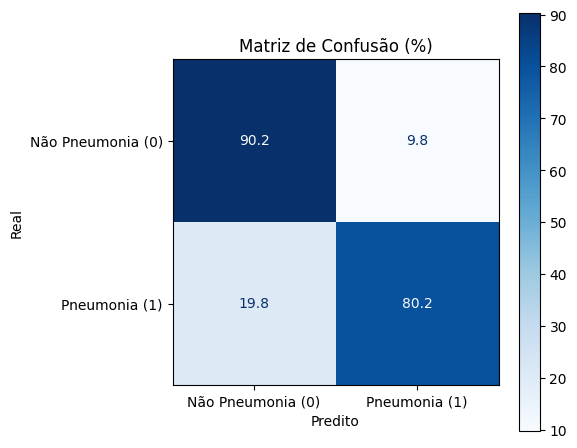


Análise da Matriz de Confusão em %:
Cada célula mostra a **porcentagem** de amostras da classe real (linha) que foi predita como a classe correspondente (coluna).
A soma das porcentagens em cada linha (horizontalmente) deve ser **100%**.


In [ ]:
"""
- MATRIZES DE CONFUSÃO:

Realiza previsões no conjunto de teste e então calcula e exibe
mapas de calor das matrizes de confusão.
"""

# Caminho para o modelo salvo (assumindo que seja o último treinado)
saved_model_path = 'best_pneumonia_resnet50_balanced_unfreeze10.keras'

# Carregar o modelo salvo
try:
    model = tf.keras.models.load_model(saved_model_path)
    print(f"Modelo carregado com sucesso de: {saved_model_path}")
except Exception as e:
    print(f"Erro ao carregar o modelo de {saved_model_path}: {e}")
    print("Certifique-se de que o caminho está correto e o arquivo existe.")
    model = None # Define model como None para evitar erros posteriores

if model is not None:
    print("Iniciando a avaliação para a matriz de confusão: Classes Reais Detalhadas vs. Predição Binária (em %)...")

    test_images_paths = balanced_test_df['image_path'].values
    test_true_binary_labels = balanced_test_df['Target'].values.astype(np.float32)
    test_true_detailed_labels = balanced_test_df['detailed_class'].values

    temp_test_dataset_for_prediction = tf.data.Dataset.from_tensor_slices((test_images_paths, test_true_binary_labels))
    temp_test_dataset_for_prediction = temp_test_dataset_for_prediction.map(tf_load_and_preprocess, num_parallel_calls=buffer_size)
    temp_test_dataset_for_prediction = temp_test_dataset_for_prediction.map(apply_transformations, num_parallel_calls=buffer_size)
    temp_test_dataset_for_prediction = temp_test_dataset_for_prediction.batch(batch_size)
    temp_test_dataset_for_prediction = temp_test_dataset_for_prediction.prefetch(buffer_size=buffer_size)

    y_pred_probs = model.predict(temp_test_dataset_for_prediction).flatten()

    y_pred_binary = (y_pred_probs > 0.5).astype(int)

    # Preparar Labels para a Matriz de Confusão
    true_labels_for_cm = test_true_detailed_labels
    predicted_labels_for_cm = np.array(['Não Pneumonia (0)' if p == 0 else 'Pneumonia (1)' for p in y_pred_binary])

    true_class_order = ['Normal', 'No Lung Opacity / Not Normal', 'Lung Opacity']
    predicted_class_order = ['Não Pneumonia (0)', 'Pneumonia (1)']

    # Gerar Matriz de Confusão
    cm_bin_abs = confusion_matrix(test_true_binary_labels, y_pred_binary, labels=[0,1])

    cm_bin_percent = cm_bin_abs.astype('float') / cm_bin_abs.sum(axis=1)[:, np.newaxis] * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_bin_percent,
                                  display_labels=['Não Pneumonia (0)', 'Pneumonia (1)'])
    fig, ax = plt.subplots(figsize=(6,5))

    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".1f")
    ax.set_title('Matriz de Confusão (%)')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()
else:
    print("Matriz de confusão não gerada pois o modelo não foi carregado com sucesso.")